# I. Librairies

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [2]:
import tensorflow as tf
print('tensorflow version:',tf.__version__)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

tensorflow version: 2.0.0
Num GPUs Available: 1


In [3]:
from generalBDDHandler import GeneralBDDHandler
from generalIOLib import FlatInputDic, GeneralOutputLib
from datasets.BatchGenerator import BatchGenerator

In [4]:
random_seed = 42

## II Description

In [5]:
general_bdd = pd.read_csv('datasets/generalIO_v2.csv', usecols = ['match_id','output'], delimiter = ";")
print(f"number of samples: {general_bdd.shape[0]}, number of matches : {len(np.unique(general_bdd['match_id']))}")

number of samples: 121536, number of matches : 503


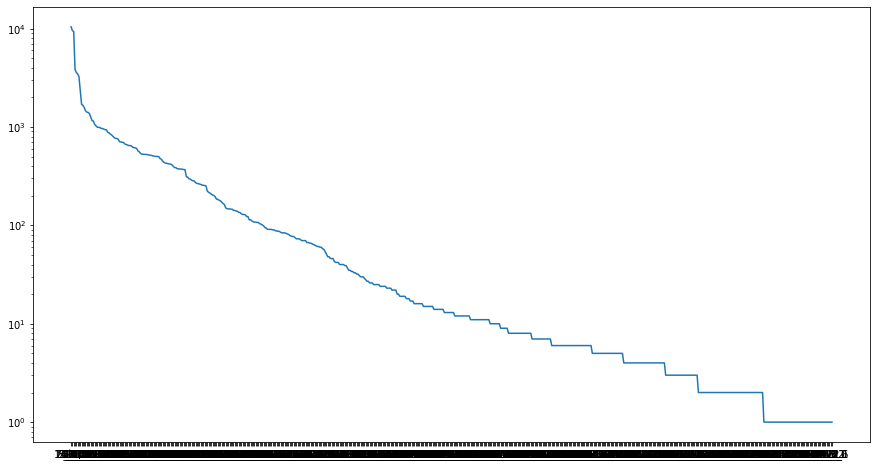

In [6]:
fig = plt.figure(figsize = (15,8))
ax = fig.add_subplot(1,1,1)

ax.plot(general_bdd['output'].value_counts(), label = 'member count per class')

ax.set_yscale('log')
plt.show()

## III Batch Generator

In [7]:
batch_size = 512
train_split = 0.8
batch_generator = BatchGenerator("datasets/generalIO_v2.csv", batch_size, train_split, random_seed )

# IV Model

In [8]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout,Flatten, Conv2D, Activation, MaxPooling2D, BatchNormalization,concatenate
from tensorflow.keras.optimizers import Adam

In [9]:
dropout_rate = 0.2

def createMLP(input_dim):
    model = Sequential()
    model.add(Dense(8, input_dim=input_dim, activation="relu"))
    model.add(Dense(8, activation="relu"))
    return model

def createCNN(width, height, depth, filters = (16,32,64)):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        #x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2,2 ),padding="same")(x)
        x = Dropout(dropout_rate)(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Activation("relu")(x)
    x = Dropout(dropout_rate)(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model

In [10]:
flatInputLib = FlatInputDic()
generalOutputLib = GeneralOutputLib()


mlp = createMLP(flatInputLib.index)
cnn = createCNN(29,15,7, filters = (16,32,64))

combinedInput = concatenate([mlp.output, cnn.output])
x = Dense(generalOutputLib.index, activation="relu")(combinedInput)
x = Dropout(dropout_rate)(x)
x = Dense(generalOutputLib.index)(x)
x = Activation('softmax')(x)

model = Model(inputs=[mlp.input, cnn.input], outputs=x)
opt = Adam(lr=1e-3) #decay=1e-3 / 200
model.compile(loss="categorical_crossentropy", metrics =['accuracy'], optimizer=opt)

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes = True, to_file='model.png')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 29, 7)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 15, 29, 16)   1024        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 15, 29, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 15, 16)    0           activation[0][0]                 
____________________________________________________________________________________________

## V Training

In [12]:
n_epochs = 10
for flat_inputs, images, outputs in batch_generator.getBatches():
    history = model.fit([flat_inputs, images],outputs, batch_size=batch_size, epochs=1, verbose = 1)

AttributeError: 'itertools.islice' object has no attribute 'close'